# PBRM1 proteomics cis comparison

"Involved in transcriptional activation and repression of select genes by chromatin remodeling (alteration of DNA-nucleosome topology). Required for the stability of the SWI/SNF chromatin remodeling complex SWI/SNF-B (PBAF). Acts as a negative regulator of cell proliferation (https://www.uniprot.org/uniprot/Q86U86).

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
sys.path.append('C:\\Users\\brittany henderson\\GitHub\\WhenMutationsMatter\\Brittany\\')
import functions as f

import cptac
import cptac.algorithms as al

## Step 2: Find the frequently mutated genes for Kidney Cancer

Enter the type of cancer and the cutoff for mutation frequency that you would like to use.

In [2]:
rc_object = cptac.RenalCcrcc()
desired_cutoff = 0.1

renal_freq_mut = al.get_frequently_mutated(rc_object, cutoff = desired_cutoff)
renal_freq_mut.loc[renal_freq_mut['Gene'] == 'PBRM1']

,Gene,Unique_Samples_Mut,Missence_Mut,Truncation_Mut
2,PBRM1,0.4,0.072727,0.336364


## Step 3: Select PBRM1, a frequently mutated gene

In [3]:
gene = 'PBRM1'

## Step 4: Select proteomics

In [4]:
omics = rc_object.get_proteomics()

## Step 5: cis comparison 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. These steps are found in the format_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

The format_cis_comparison_data does the first 3 steps.

In [5]:
rc_status = f.format_cis_comparison_data(rc_object, 'proteomics', gene)

In [6]:
omics_col_list = [gene+'_proteomics']
prot_col = gene+"_proteomics"

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(rc_status, 'binary_mutations', omics_col_list)
print(significant_pval_results)

Doing t-test comparison

         Comparison       P_Value
0  PBRM1_proteomics  1.657330e-10


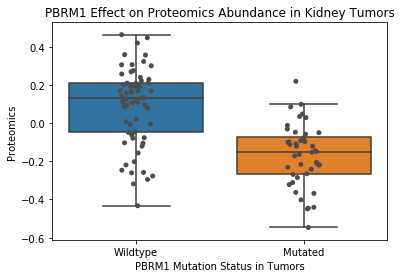

In [7]:
# Step 5 - Create boxplt to compare wildtype and mutated effect on omics data
cis_boxplot = sns.boxplot(data = rc_status, x = 'binary_mutations',
                          y = prot_col, order = ["Wildtype","Mutated"], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on Proteomics Abundance in Kidney Tumors")
cis_boxplot = sns.stripplot(data= rc_status, x = 'binary_mutations',
                            y = prot_col,jitter = True, color = ".3", order = ["Wildtype","Mutated"])
cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()

PBRM1 proteomics decreased in the PBRM1 mutated samples compared to the wildtype.

# Compare missense and truncation mutation types

In [24]:
rc_type = f.get_missence_truncation_comparison(rc_object, 'proteomics', gene)

print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(rc_type, 'binary_mutations', omics_col_list)
print(significant_pval_results)

Doing t-test comparison

No significant comparisons.
None


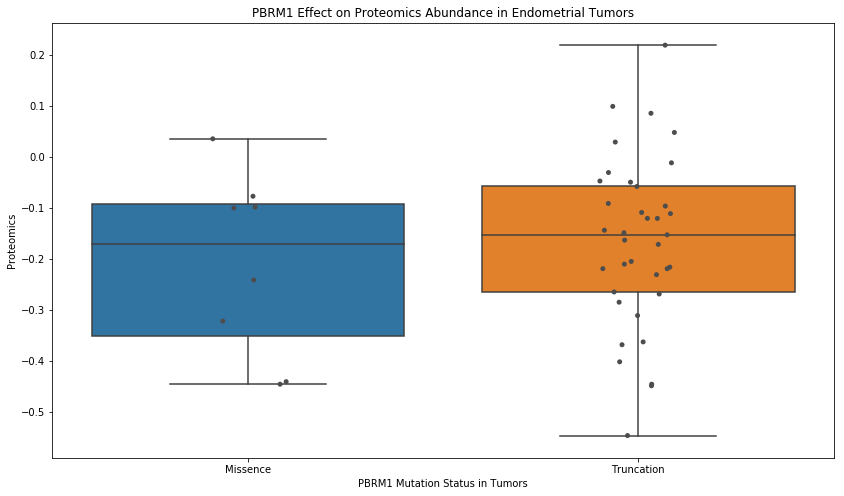

In [25]:
rc_cis_boxplot = sns.boxplot(data = rc_type, x = 'binary_mutations',
                          y = prot_col, order = ["Missence","Truncation"], showfliers = False)  
rc_cis_boxplot.set_title(gene + " Effect on Proteomics Abundance in Endometrial Tumors")
rc_cis_boxplot = sns.stripplot(data= rc_type, x = 'binary_mutations',
                            y = prot_col, jitter = True, color = ".3", order = ["Missence","Truncation"])
rc_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()

# Compare specific mutations

Find the common specific muatations and compare them to the wildtype tumors.

In [35]:
# Find common mutations
somatic_mutations = rc_object.get_mutations()
gene_mutations = somatic_mutations.loc[somatic_mutations['Gene'] == gene].reset_index() #select gene
mut_counts = gene_mutations.groupby('Mutation').nunique() # count unique samples for each specific mutation
sorted_counts = mut_counts.sort_values(by='Sample_ID', ascending=False) #sort descending
mutation_counts = sorted_counts.rename({'Sample_ID': 'Unique_Sample_Count'}, axis=1)
mutation_counts['Unique_Sample_Count']

Mutation
Frame_Shift_Del      16
Nonsense_Mutation    13
Missense_Mutation     6
Frame_Shift_Ins       4
Splice_Site           4
In_Frame_Del          2
Name: Unique_Sample_Count, dtype: int64

In [37]:
# Make a list of common mutations 
cutoff = 9
common_mutations = mutation_counts.loc[mutation_counts['Unique_Sample_Count'] > cutoff]
common_mutations_list = list(common_mutations.index)
common_mutations_list

['Frame_Shift_Del', 'Nonsense_Mutation']

Doing t-test comparison for Frame_Shift_Del vs Wildtype_Tumors

         Comparison   P_Value
0  PBRM1_proteomics  0.000089


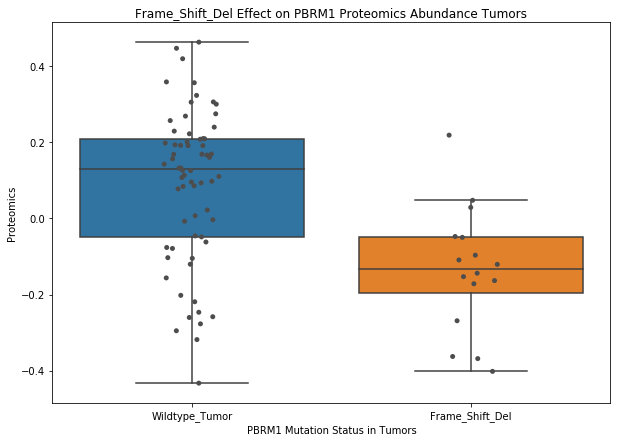

Doing t-test comparison for Nonsense_Mutation vs Wildtype_Tumors

         Comparison   P_Value
0  PBRM1_proteomics  0.000004


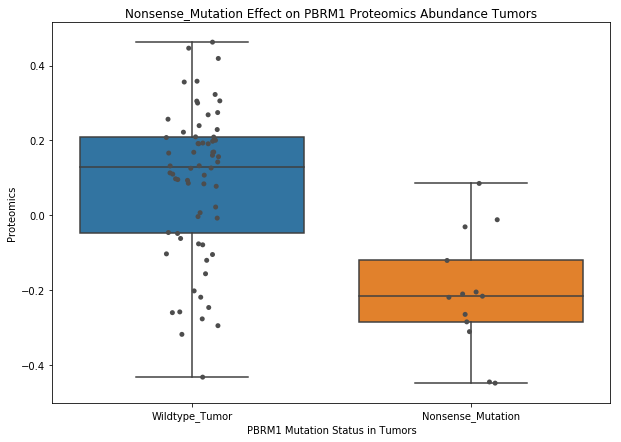

In [38]:
for mut in common_mutations_list:
    filtered_mutation = rc_object.join_omics_to_mutations(omics_df_name="proteomics", mutations_genes=gene, 
                                                        omics_genes=gene, 
                                                        mutations_filter=[mut])
    # Select binary values using bool
    mutation_bool = filtered_mutation[gene+'_Mutation'].isin([mut, 'Wildtype_Tumor']) 
    binary_mut = filtered_mutation[mutation_bool] #pandas keeps rows where true
    
    # run T-test
    print("Doing t-test comparison for", mut, "vs Wildtype_Tumors\n")
    significant_pval_results = al.wrap_ttest(binary_mut, gene+'_Mutation', omics_col_list)
    print(significant_pval_results)
    
    # Visualize
    # FUNCTION TO SIMPLIFY?
    plt.rcParams['figure.figsize']=(10,7)
    rc_cis_boxplot = sns.boxplot(data = binary_mut, x = 'PBRM1_Mutation',
                              y = gene+'_proteomics', order=['Wildtype_Tumor',mut], showfliers = False)  
    rc_cis_boxplot.set_title(mut + " Effect on " + gene + " Proteomics Abundance Tumors")
    rc_cis_boxplot = sns.stripplot(data= binary_mut, x = 'PBRM1_Mutation',
                                y = gene+'_proteomics', order=['Wildtype_Tumor',mut], jitter = True, color = ".3")
    rc_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
    plt.show()
    
    plt.clf()
    plt.close()


# Visualize all Mutations

In [39]:
# What should be the priority?
mutation_prot = rc_object.join_omics_to_mutations(omics_df_name="proteomics", mutations_genes=gene, 
                                                        omics_genes=gene,
                                                    mutations_filter=['Nonsense_Mutation'])

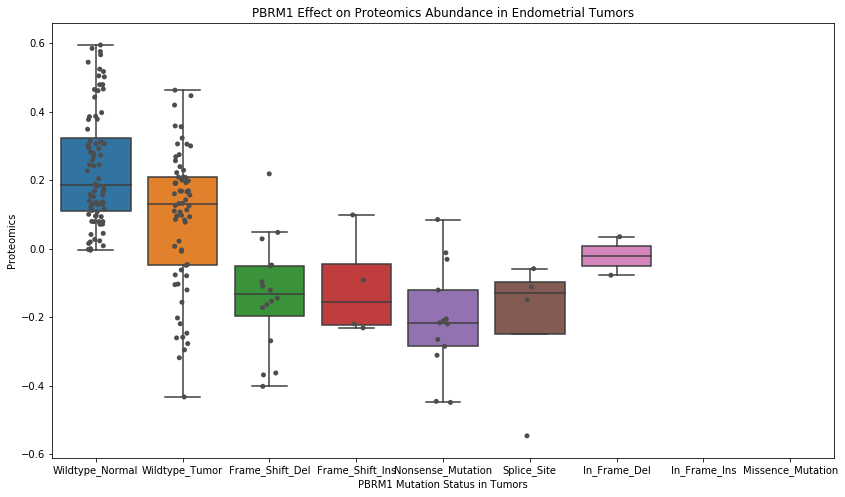

In [41]:
plt.rcParams['figure.figsize']=(14,8)
rc_cis_boxplot = sns.boxplot(data = mutation_prot,
                             x = gene+'_Mutation',
                             y = gene+'_proteomics', 
                             order=['Wildtype_Normal', 'Wildtype_Tumor', 'Frame_Shift_Del', 
                                    'Frame_Shift_Ins', 'Nonsense_Mutation', 'Splice_Site',
                                    'In_Frame_Del', 'In_Frame_Ins', 'Missence_Mutation'],
                             showfliers = False)  
rc_cis_boxplot.set_title(gene + " Effect on Proteomics Abundance in Endometrial Tumors")
rc_cis_boxplot = sns.stripplot(data= mutation_prot, 
                               x = gene+'_Mutation',
                               y = gene+'_proteomics', 
                               order=['Wildtype_Normal', 'Wildtype_Tumor', 'Frame_Shift_Del', 
                                    'Frame_Shift_Ins', 'Nonsense_Mutation', 'Splice_Site',
                                    'In_Frame_Del', 'In_Frame_Ins', 'Missence_Mutation'],
                               jitter = True, color = ".3")
rc_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()

# Analysis of Results

PBRM1 proteomics decreased in the PBRM1 mutated samples compared to the wildtype. Two significant common truncations (nonsense and frame shift del) also showed a decrease in PBRM1 proteomics.